# Fitting data with python

After reading this notebook, you will know
* how to fit functions with scipy's curve_fit function
* make the fitting more robust
* how to fit compound models
* evaluate the fit quality

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (15, 8)

from scipy.optimize import curve_fit, minimize
from scipy.stats import *
import numpy as np

In [2]:
# Create some synthetical data

np.random.seed(15)
x = np.arange(-5, 20, 0.01)
lin_model = 0.3*x + 1
non_lin_model = 0.01*x*x + lin_model

noise = np.random.randn(len(x))/2
gauss_model = norm.pdf(x, loc=5, scale=2)*50

data = non_lin_model + gauss_model 
data_noise = data + noise

# What is a compound model?

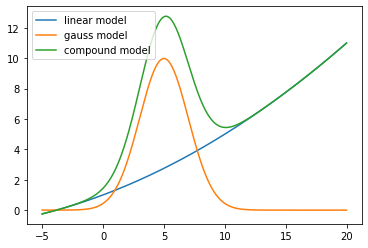

In [3]:
plt.plot(x, non_lin_model, label='linear model')
plt.plot(x, gauss_model, label='gauss model')
plt.plot(x, data, label='compound model')
plt.legend()

# A compound model is the superposition of models

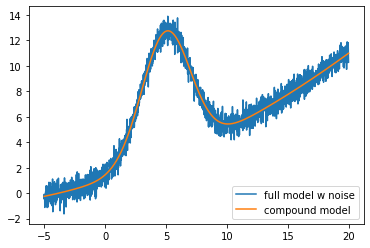

In [4]:
plt.plot(x, data_noise, label='full model w noise')
plt.plot(x, data, label='compound model')
plt.legend()

# Define fitting functions

In [5]:
def linear_model(x, a, b):
    return a*x + b

def non_linear_model(x, a, b, c):
    return a*x*x + b*x + c

def norm_model(x, x0, sigma, n0):
    return n0 * ((np.sqrt(2*np.pi)*sigma)**0.5) * np.exp(-(x-x0)**2 / (2*sigma))

#def my_model(x, *params):
#    return linear_model(x, *params[:2]) + norm_model(x, *params[2:])

def my_model(x, *params):
    return non_linear_model(x, *params[:3]) + norm_model(x, *params[3:6])

# Fit the data

In [6]:
p0 = (0.01, 0.3, 1, 5, 2, 5)
bounds = ((0.0, 0.0, 0.0, 2, 0.05, 3), \
          (1.0, 2.0, 10, 10, 5, 10))

popt, pcov = curve_fit(my_model, x, data_noise, p0=p0)
popt

# try fitting the data without p0 and bounds first
# if this does not work, add p0
# if this does not help, add bounds as well

array([0.01065679, 0.29239493, 0.95790922, 5.00640182, 4.0124754 ,
       3.17402287])

In [7]:
# these errors help you assess the robustness of the fit parameters
# if perr << popt, then your fit is not reliable at all
# try other p0 or boundary conditions

perr = np.sqrt(np.diag(pcov))
perr

array([0.00031148, 0.00453293, 0.02197826, 0.00775957, 0.03983997,
       0.01996197])

# Plot fit results

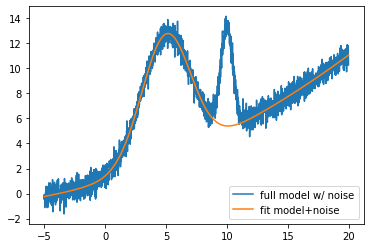

In [11]:
plt.plot(x, data_noise, label='full model w/ noise')
plt.plot(x, my_model(x, *popt), label='fit model+noise')
plt.legend()

# fit looks good, right?
# let's try to fit some more complex data

# Complex models

In [12]:
gauss_model_2 = norm.pdf(x, loc=10, scale=0.5)*10

data = non_lin_model + gauss_model + gauss_model_2 
data_noise = data + noise

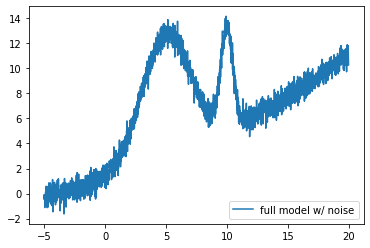

In [14]:
plt.plot(x, data_noise, label='full model w/ noise')
plt.legend()

# Define the new model

In [15]:
def my_model(x, *params):
    return non_linear_model(x, *params[:3]) + norm_model(x, *params[3:6]) + norm_model(x, *params[6:])

# Fit the complex model

In [16]:
p0 = (0.01, 0.3, 1, \
      5, 2, 5, \
      10, 0.1, 2)

bounds = ((0.0, 0.0, 0.0, \
           2, 0.05, 3, \
           7, 0.01, 1), \
          (1.0, 2.0, 10, \
           10, 5, 10, \
           14, 3, 10))

popt, pcov = curve_fit(my_model, x, data_noise, p0=p0)
popt

array([ 0.01050545,  0.29466297,  0.96494547,  5.00746623,  4.01397498,
        3.16761873, 10.00111957,  0.24376356, 10.22524208])

In [17]:
perr = np.sqrt(np.diag(pcov))
perr

array([0.00035063, 0.00512155, 0.02336629, 0.00784793, 0.04072575,
       0.02080213, 0.00477637, 0.00500299, 0.1615107 ])

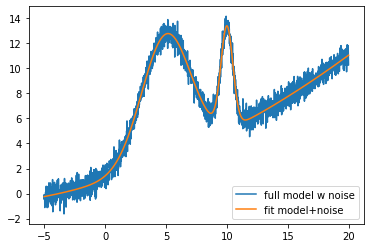

In [18]:
plt.plot(x, data_noise, label='full model w noise')
plt.plot(x, my_model(x, *popt), label='fit model+noise')
plt.legend()

# fit looks good as well
# can we trust the fit?

# Evaluating the fit quality

## Residuals

In [19]:
# choose 0.5 as the random error for y, should be determined from data
# see variable "noise"
uncertainty = np.ones(len(x))/2

residual = (data_noise - my_model(x, *popt))/uncertainty

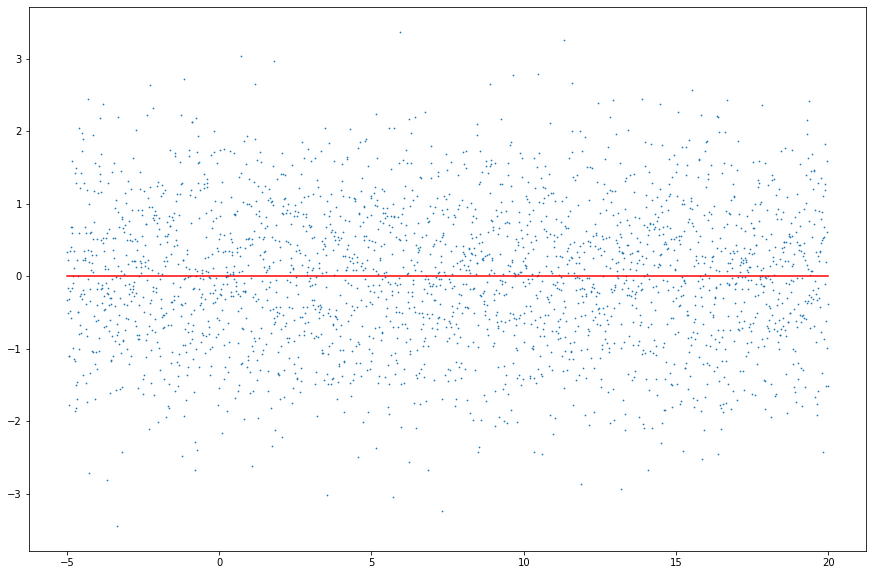

In [20]:
plt.figure(figsize=(15, 10))
plt.scatter(x, residual, label='residuals', s=0.5)
plt.plot([x.min(), x.max()], [0., 0.], 'r-')
# you can try a boxplot or violinplot as well

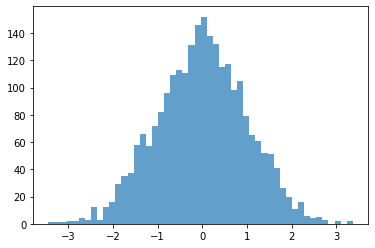

In [21]:
plt.hist(residual, bins=50, alpha=0.7);

# residuals seem to be normally distributed, which is good
# could be fitted again with a normal distribution

In [22]:
np.percentile(residual, q=(16, 84)), norm.interval(0.68)

(array([-1.00360413,  1.00019099]), (-0.994457883209753, 0.9944578832097535))

In [23]:
np.percentile(residual, q=(2.5, 97.5)), norm.interval(0.95)

(array([-1.91958782,  1.91072999]), (-1.959963984540054, 1.959963984540054))

In [24]:
np.percentile(residual, q=(0.5, 99.5)), norm.interval(0.99)

(array([-2.53378924,  2.4475571 ]), (-2.5758293035489004, 2.5758293035489004))

In [25]:
# percentiles are close to the expectation values of the theoretical distribution

# (Reduced) $\chi^2$

In [26]:
n_params = 9

reduced_chi_square = sum(residual**2) / (len(x) - 9)
reduced_chi_square

# result is close to 1, a indication for a good fit
# reads as: data deviates about 1 sigma from the fit

0.9989967460431061

# Evaluating fit parameters

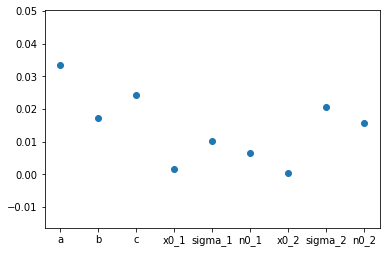

In [27]:
# error estimates for the parameters fulfill popt >> perr

plt.scatter(range(len(perr)), perr/popt)
plt.xticks(range(len(perr)), ['a', 'b', 'c', 'x0_1', 'sigma_1', 'n0_1', 'x0_2', 'sigma_2', 'n0_2']);

In [29]:
# to be continued

In [30]:
# need to verify parameter covariances for robustness of the fit

np.where(pcov[pcov>0.01])

(array([0], dtype=int64),)

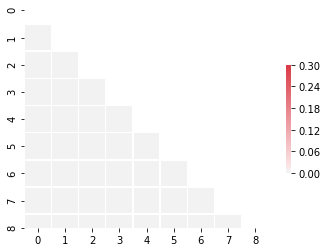

In [31]:
import seaborn as sb
mask = np.zeros_like(pcov, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sb.diverging_palette(220, 10, as_cmap=True)

sb.heatmap(pcov, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})